https://github.com/kr-colab/spaceness/blob/master/batch_scripts/runslim_spatial.srun

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# sigma = np.random.uniform(.2, 4)

In [3]:
sigmas = np.linspace(.2, 4, 4)
chrom_lens = np.linspace(1e3, 1e8, 4).astype(int)

In [4]:
commands = [f"(mkdir -p out/{sigma:.4f}_{chrom_len}; slim-4.2.2 -d G={chrom_len} -d sigma={sigma:.4f} -d outpath=\"'out/{sigma:.4f}_{chrom_len}'\" profiling.slim > out/{sigma:.4f}_{chrom_len}/outerr.log 2>&1) &"
            for chrom_len in chrom_lens for sigma in sigmas]

In [5]:
import os
import stat
def write_prof_script(filename):
    with open(filename, 'w') as script:
        script.write('#!/usr/bin/env bash\n') 
        script.write('set -euo pipefail\n') 
        script.write('mkdir out\n')
        for command in commands:
            script.write(command)
            script.write('\n')
        script.write('wait -n\n')
    os.chmod('profiling/run-slim', os.stat('profiling/run-slim').st_mode | stat.S_IEXEC)
# write_prof_script('profiling/run-slim')

In [16]:
def parse_stats_csv(filename):
    time_columns = ['sim_duration', 'cycle_duration_mean', 'cycle_duration_pvar', 'cycle_duration_stdev']
    return (
        # python engine to parse timedeltas
        pd.read_csv(filename, engine="python", dtype={c: 'timedelta64[ns]' for c in time_columns})
        .sort_values(['chrom_len', 'sigma'])
        .assign(
            cycle_duration_mean_minutes=lambda df: df.cycle_duration_mean.apply(lambda dt: dt.total_seconds() / 60),
            cycle_duration_pvar_minutes=lambda df: df.cycle_duration_pvar.apply(lambda dt: dt.total_seconds() / 60),
            cycle_duration_stdev_minutes=lambda df: df.cycle_duration_stdev.apply(lambda dt: dt.total_seconds() / 60),
            sim_duration_hours=lambda df: df.sim_duration.apply(lambda dt: dt.total_seconds() / 60 / 60),
         )
    )

In [17]:
prof_result = parse_stats_csv('profile-stats.csv')

In [18]:
prof_result

,sigma,chrom_len,sim_duration,cycle_duration_mean,cycle_duration_stdev,cycle_duration_pvar,cycle_duration_mean_minutes,cycle_duration_pvar_minutes,cycle_duration_stdev_minutes,sim_duration_hours
13,0.2000,1000,0 days 03:08:49,0 days 00:00:56.645000,0 days 00:00:12.587741,0 days 00:02:37.658975,0.944083,2.627650,0.209796,3.146944
9,1.4667,1000,0 days 13:50:46,0 days 00:04:09.230000,0 days 00:00:57.949615,0 days 00:55:41.367100,4.153833,55.689452,0.965827,13.846111
12,2.7333,1000,1 days 02:00:25,0 days 00:07:48.125000,0 days 00:02:38.373388,0 days 06:55:56.719375,7.802083,415.945323,2.639556,26.006944
0,4.0000,1000,1 days 03:22:44,0 days 00:08:12.820000,0 days 00:01:32.164031,0 days 02:20:51.737600,8.213667,140.862293,1.536067,27.378889
8,0.2000,33334000,0 days 03:09:31,0 days 00:00:56.855000,0 days 00:00:09.223303,0 days 00:01:24.643975,0.947583,1.410733,0.153722,3.158611
1,1.4667,33334000,0 days 13:46:40,0 days 00:04:08,0 days 00:00:52.893085,0 days 00:46:23.690000,4.133333,46.394833,0.881551,13.777778
3,2.7333,33334000,1 days 02:41:57,0 days 00:08:00.585000,0 days 00:02:40.877065,0 days 07:09:12.022775,8.009750,429.200380,2.681284,26.699167
11,4.0000,33334000,1 days 03:55:48,0 days 00:08:22.740000,0 days 00:01:54.597843,0 days 03:37:47.002400,8.379000,217.783373,1.909964,27.930000
5,0.2000,66667000,0 days 03:39:55,0 days 00:01:05.975000,0 days 00:00:08.959113,0 days 00:01:19.864375,1.099583,1.331073,0.149319,3.665278
10,1.4667,66667000,0 days 14:40:59,0 days 00:04:24.295000,0 days 00:01:08.071408,0 days 01:16:50.547975,4.404917,76.842466,1.134523,14.683056


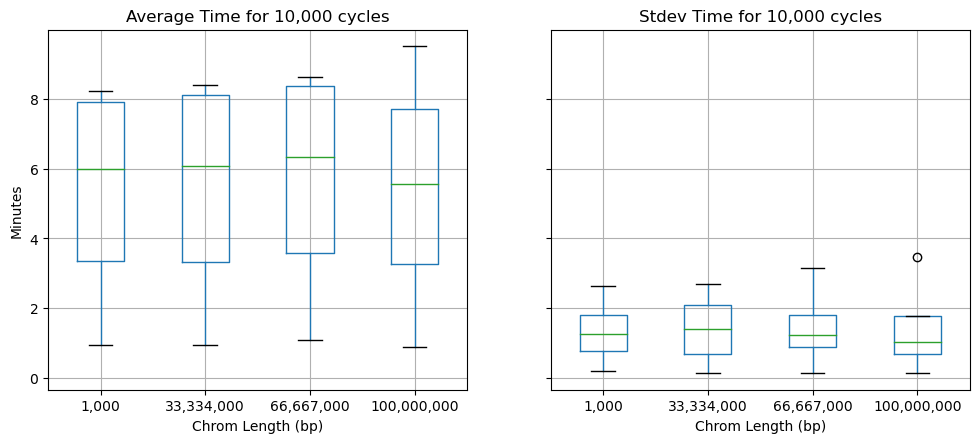

In [19]:
(prof_result
 .boxplot(
     ['cycle_duration_mean_minutes', 'cycle_duration_stdev_minutes'],
     by='chrom_len',
     figsize=(plt.rcParams['figure.figsize'][0] * 1.8, plt.rcParams['figure.figsize'][1]))
)
plt.gcf().axes[0].set_title('Average Time for 10,000 cycles')
plt.gcf().axes[1].set_title('Stdev Time for 10,000 cycles')
plt.suptitle(None)
plt.gcf().axes[0].set_ylabel('Minutes')
[ax.set_xlabel('Chrom Length (bp)') for ax in plt.gcf().axes]
plt.xticks(
    np.arange(len(prof_result.chrom_len.drop_duplicates())) + 1,
    prof_result.chrom_len.drop_duplicates().apply(lambda x: f'{x:,}').tolist()
)
plt.show()

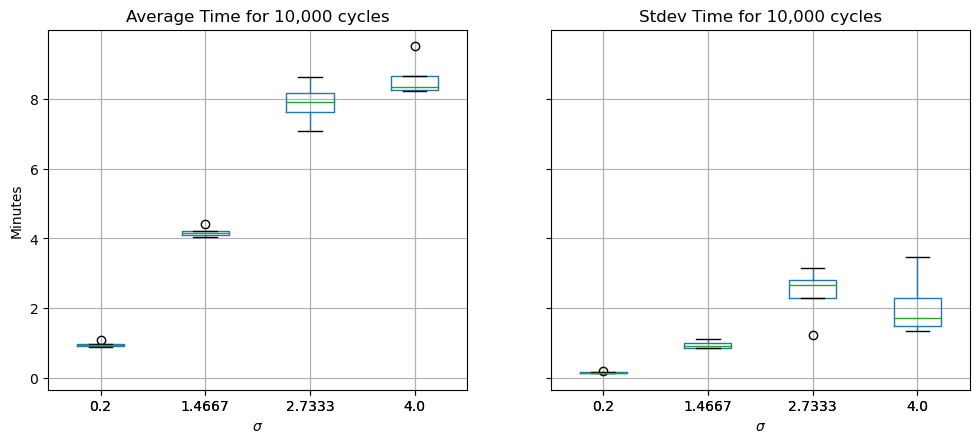

In [20]:
(prof_result
 .boxplot(
     ['cycle_duration_mean_minutes', 'cycle_duration_stdev_minutes'],
     by='sigma',
     figsize=(plt.rcParams['figure.figsize'][0] * 1.8, plt.rcParams['figure.figsize'][1]))
)
plt.gcf().axes[0].set_title('Average Time for 10,000 cycles')
plt.gcf().axes[1].set_title('Stdev Time for 10,000 cycles')
plt.suptitle(None)
plt.gcf().axes[0].set_ylabel('Minutes')
[ax.set_xlabel('$\sigma$') for ax in plt.gcf().axes]
plt.show()

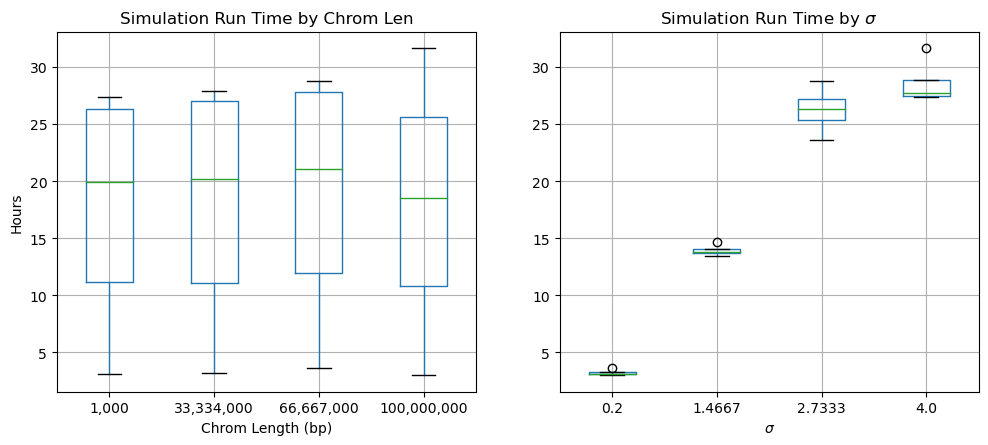

In [21]:
plt.subplots(1, 2, figsize=(plt.rcParams['figure.figsize'][0] * 1.8, plt.rcParams['figure.figsize'][1]))
prof_result.boxplot('sim_duration_hours', by='chrom_len', ax=plt.gcf().axes[0])
prof_result.boxplot('sim_duration_hours', by='sigma', ax=plt.gcf().axes[1])
plt.gcf().axes[0].set_title('Simulation Run Time by Chrom Len')
plt.gcf().axes[1].set_title('Simulation Run Time by $\sigma$')
plt.suptitle(None)
plt.gcf().axes[0].set_ylabel('Hours')
plt.gcf().axes[0].set_xlabel('Chrom Length (bp)')
plt.gcf().axes[1].set_xlabel('$\sigma$')
plt.gcf().axes[0].set_xticks(
    np.arange(len(prof_result.chrom_len.drop_duplicates())) + 1,
    prof_result.chrom_len.drop_duplicates().apply(lambda x: f'{x:,}').tolist()
)
plt.show()

In [22]:
cycle_duration_stats = pd.DataFrame([prof_result.groupby('sigma').cycle_duration_mean_minutes.mean(), prof_result.groupby('sigma').cycle_duration_pvar_minutes.mean()]).T
cycle_duration_stats.columns = ['mean', 'var']
cycle_duration_stats

,mean,var
sigma,,
0.2000,0.972354,1.622855
1.4667,4.184333,55.752329
2.7333,7.882750,382.143052
4.0000,8.593354,295.518199


In [23]:
cycle_duration_stats['mean'] * (2_000_000 / 10_000) / 60

sigma
0.2000     3.241181
1.4667    13.947778
2.7333    26.275833
4.0000    28.644514
Name: mean, dtype: float64

In [24]:
(cycle_duration_stats['var'] * (2_000_000 / 10_000) / 60).apply(np.sqrt)

sigma
0.2000     2.325837
1.4667    13.632355
2.7333    35.690477
4.0000    31.385676
Name: var, dtype: float64

In [25]:
prof_result.set_index('sigma').sort_index().cycle_duration_stdev_minutes * 200 / 60

sigma
0.2000     0.699319
0.2000     0.512406
0.2000     0.497728
0.2000     0.456963
1.4667     3.219423
1.4667     2.938505
1.4667     3.781745
1.4667     2.864343
2.7333     8.798522
2.7333     8.937615
2.7333    10.508967
2.7333     4.093661
4.0000     5.120224
4.0000     6.366547
4.0000     4.501723
4.0000    11.532010
Name: cycle_duration_stdev_minutes, dtype: float64

In [43]:
prof_result_mut = parse_stats_csv('profile-stats-mut.csv')

In [44]:
prof_result_mut

,sigma,chrom_len,sim_duration,cycle_duration_mean,cycle_duration_stdev,cycle_duration_pvar,cycle_duration_mean_minutes,cycle_duration_pvar_minutes,cycle_duration_stdev_minutes,sim_duration_hours
13,0.2000,1000,0 days 03:42:34,0 days 00:01:06.770000,0 days 00:00:09.896809,0 days 00:01:37.457100,1.112833,1.624285,0.164947,3.709444
9,1.4667,1000,0 days 11:36:56,0 days 00:05:12.059701,0 days 00:01:27.875147,0 days 02:07:44.414346,5.200995,127.740239,1.464586,11.615556
12,2.7333,1000,0 days 11:27:59,0 days 00:10:55.222222,0 days 00:02:33.135555,0 days 06:24:38.268078,10.920370,384.637801,2.552259,11.466389
0,4.0000,1000,0 days 11:31:39,0 days 00:13:18.057692,0 days 00:03:15.571101,0 days 10:25:12.515902,13.300962,625.208598,3.259518,11.527500
8,0.2000,33334000,0 days 11:35:46,0 days 00:05:09.229630,0 days 00:01:34.669333,0 days 02:28:15.895418,5.153827,148.264924,1.577822,11.596111
1,1.4667,33334000,0 days 11:39:24,0 days 00:08:44.550000,0 days 00:01:26.032655,0 days 02:01:49.097500,8.742500,121.818292,1.433878,11.656667
3,2.7333,33334000,0 days 11:28:23,0 days 00:13:29.862745,0 days 00:02:46.888468,0 days 07:35:05.647828,13.497712,455.094130,2.781474,11.473056
11,4.0000,33334000,0 days 11:35:24,0 days 00:12:25.071429,0 days 00:02:34.304640,0 days 06:29:44.744898,12.417857,389.745748,2.571744,11.590000
5,0.2000,66667000,0 days 11:34:20,0 days 00:09:46.760563,0 days 00:04:35.839522,0 days 20:50:15.787741,9.779343,1250.263129,4.597325,11.572222
10,1.4667,66667000,0 days 11:38:15,0 days 00:12:02.327586,0 days 00:02:11.186407,0 days 04:41:53.151308,12.038793,281.885855,2.186440,11.637500


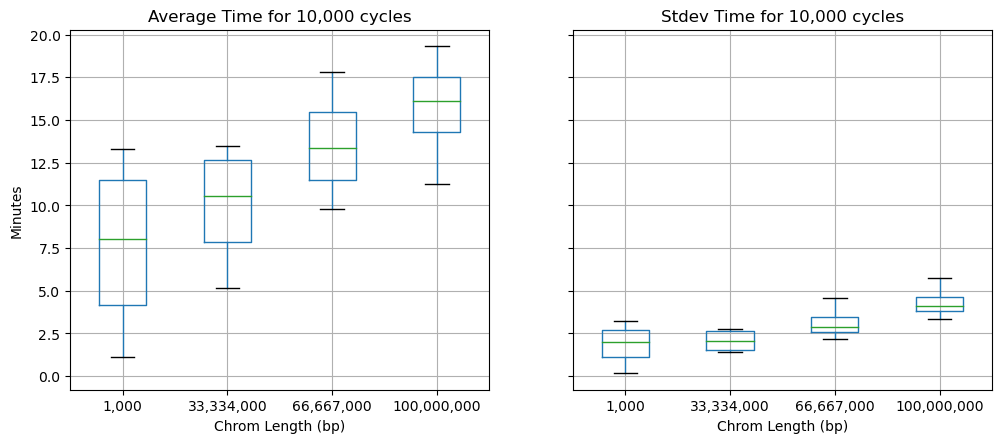

In [45]:
(prof_result_mut
 .boxplot(
     ['cycle_duration_mean_minutes', 'cycle_duration_stdev_minutes'],
     by='chrom_len',
     figsize=(plt.rcParams['figure.figsize'][0] * 1.8, plt.rcParams['figure.figsize'][1]))
)
plt.gcf().axes[0].set_title('Average Time for 10,000 cycles')
plt.gcf().axes[1].set_title('Stdev Time for 10,000 cycles')
plt.suptitle(None)
plt.gcf().axes[0].set_ylabel('Minutes')
[ax.set_xlabel('Chrom Length (bp)') for ax in plt.gcf().axes]
plt.xticks(
    np.arange(len(prof_result.chrom_len.drop_duplicates())) + 1,
    prof_result.chrom_len.drop_duplicates().apply(lambda x: f'{x:,}').tolist()
)
plt.show()

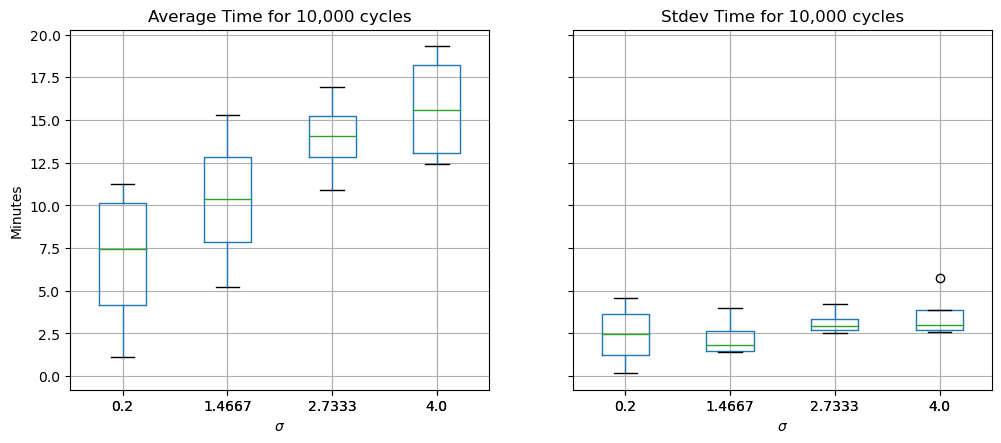

In [46]:
(prof_result_mut
 .boxplot(
     ['cycle_duration_mean_minutes', 'cycle_duration_stdev_minutes'],
     by='sigma',
     figsize=(plt.rcParams['figure.figsize'][0] * 1.8, plt.rcParams['figure.figsize'][1]))
)
plt.gcf().axes[0].set_title('Average Time for 10,000 cycles')
plt.gcf().axes[1].set_title('Stdev Time for 10,000 cycles')
plt.suptitle(None)
plt.gcf().axes[0].set_ylabel('Minutes')
[ax.set_xlabel('$\sigma$') for ax in plt.gcf().axes]
plt.show()

In [47]:
cycle_duration_stats_mut = pd.DataFrame([prof_result_mut.groupby('sigma').cycle_duration_mean_minutes.mean(), prof_result_mut.groupby('sigma').cycle_duration_pvar_minutes.mean()]).T
cycle_duration_stats_mut.columns = ['mean', 'var']
cycle_duration_stats_mut

,mean,var
sigma,,
0.2000,6.829243,512.704339
1.4667,10.313905,367.758578
2.7333,13.997874,613.762628
4.0000,15.720472,847.945987


In [49]:
cycle_duration_stats_mut['mean'] * (2_000_000 / 10_000) / 60

sigma
0.2000    22.764142
1.4667    34.379685
2.7333    46.659580
4.0000    52.401574
Name: mean, dtype: float64

In [50]:
(cycle_duration_stats_mut['var'] * (2_000_000 / 10_000) / 60).apply(np.sqrt)

sigma
0.2000    41.340228
1.4667    35.012311
2.7333    45.231354
4.0000    53.164712
Name: var, dtype: float64

In [52]:
prof_result_mut.set_index('sigma').sort_index().cycle_duration_stdev_minutes * 200 / 60

sigma
0.2000     0.549823
0.2000     5.259407
0.2000    15.324418
0.2000    11.066563
1.4667     4.881953
1.4667     4.779592
1.4667     7.288134
1.4667    13.339889
2.7333     8.507531
2.7333     9.271582
2.7333    10.262263
2.7333    14.176080
4.0000    10.865061
4.0000     8.572480
4.0000     9.088720
4.0000    19.233904
Name: cycle_duration_stdev_minutes, dtype: float64

In [54]:
prof_result_neut_mut = parse_stats_csv('profile-stats-neutral-mut.csv')

In [55]:
prof_result_neut_mut

,sigma,chrom_len,sim_duration,cycle_duration_mean,cycle_duration_stdev,cycle_duration_pvar,cycle_duration_mean_minutes,cycle_duration_pvar_minutes,cycle_duration_stdev_minutes,sim_duration_hours
12,0.2000,1000,0 days 00:54:25,0 days 00:01:30.694444,0 days 00:00:16.186095,0 days 00:04:14.712191,1.511574,4.245203,0.269768,0.906944
4,1.4667,1000,0 days 00:50:27,0 days 00:08:24.500000,0 days 00:01:11.135786,0 days 01:10:16.916667,8.408333,70.281944,1.185596,0.840833
13,2.7333,1000,0 days 00:43:20,0 days 00:14:26.666667,0 days 00:00:21.548395,0 days 00:05:09.555556,14.444444,5.159259,0.359140,0.722222
2,4.0000,1000,0 days 00:46:35,0 days 00:15:31.666667,0 days 00:00:04.932883,0 days 00:00:16.222222,15.527778,0.270370,0.082215,0.776389
8,0.2000,33334000,0 days 00:49:43,0 days 00:06:12.875000,0 days 00:00:30.135112,0 days 00:13:14.609375,6.214583,13.243490,0.502252,0.828611
3,1.4667,33334000,0 days 00:53:42,0 days 00:08:57,0 days 00:00:22.733236,0 days 00:07:10.666667,8.950000,7.177778,0.378887,0.895000
11,2.7333,33334000,0 days 00:54:38,0 days 00:13:39.500000,0 days 00:00:09.146948,0 days 00:01:02.750000,13.658333,1.045833,0.152449,0.910556
7,4.0000,33334000,0 days 00:49:00,0 days 00:16:20,0 days 00:00:10.148892,0 days 00:01:08.666667,16.333333,1.144444,0.169148,0.816667
0,0.2000,66667000,0 days 00:54:31,0 days 00:10:54.200000,0 days 00:01:22.526965,0 days 01:30:48.560000,10.903333,90.809333,1.375449,0.908611
15,1.4667,66667000,0 days 00:47:26,0 days 00:09:29.200000,0 days 00:00:31.356020,0 days 00:13:06.560000,9.486667,13.109333,0.522600,0.790556


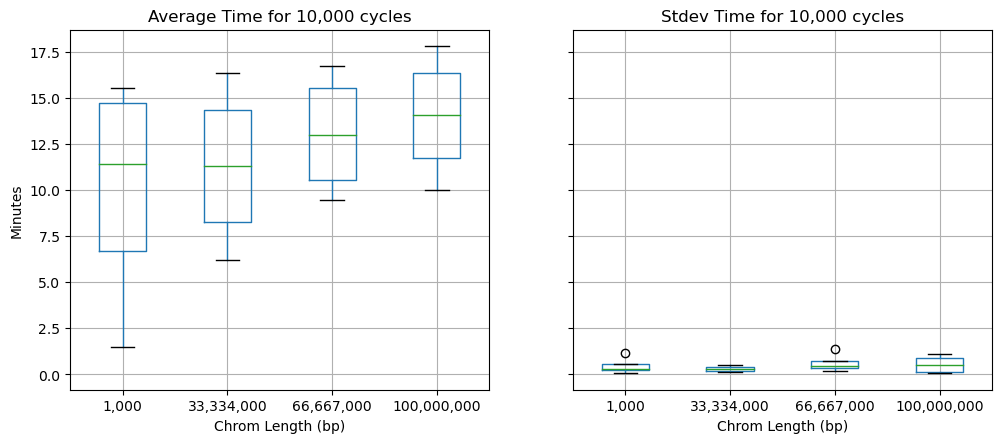

In [57]:
(prof_result_neut_mut
 .boxplot(
     ['cycle_duration_mean_minutes', 'cycle_duration_stdev_minutes'],
     by='chrom_len',
     figsize=(plt.rcParams['figure.figsize'][0] * 1.8, plt.rcParams['figure.figsize'][1]))
)
plt.gcf().axes[0].set_title('Average Time for 10,000 cycles')
plt.gcf().axes[1].set_title('Stdev Time for 10,000 cycles')
plt.suptitle(None)
plt.gcf().axes[0].set_ylabel('Minutes')
[ax.set_xlabel('Chrom Length (bp)') for ax in plt.gcf().axes]
plt.xticks(
    np.arange(len(prof_result_neut_mut.chrom_len.drop_duplicates())) + 1,
    prof_result_neut_mut.chrom_len.drop_duplicates().apply(lambda x: f'{x:,}').tolist()
)
plt.show()

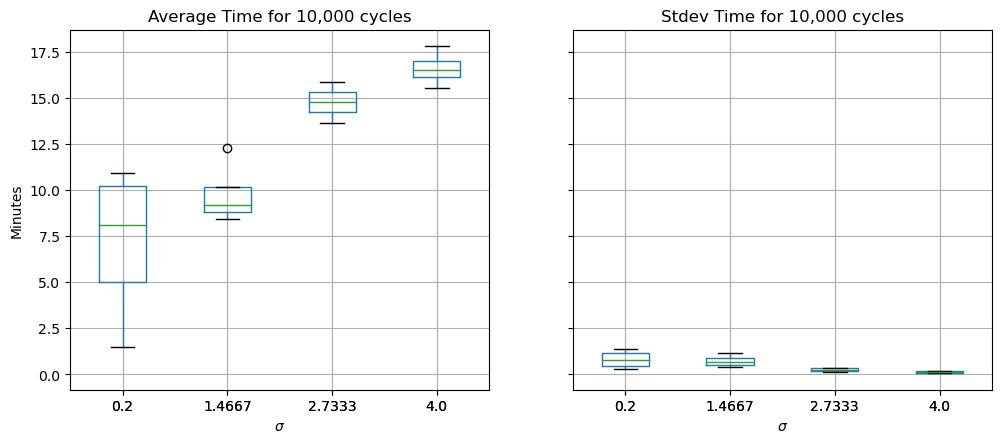

In [58]:
(prof_result_neut_mut
 .boxplot(
     ['cycle_duration_mean_minutes', 'cycle_duration_stdev_minutes'],
     by='sigma',
     figsize=(plt.rcParams['figure.figsize'][0] * 1.8, plt.rcParams['figure.figsize'][1]))
)
plt.gcf().axes[0].set_title('Average Time for 10,000 cycles')
plt.gcf().axes[1].set_title('Stdev Time for 10,000 cycles')
plt.suptitle(None)
plt.gcf().axes[0].set_ylabel('Minutes')
[ax.set_xlabel('$\sigma$') for ax in plt.gcf().axes]
plt.show()